In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 데이터 경로 지정
path2data = './data'
os.makedirs(path2data, exist_ok=True)
# transforms 정의하기
h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
                    transforms.Resize((h,w)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
])
# STL-10 dataset 불러오기
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transform)

Files already downloaded and verified


torch.Size([3, 64, 64])


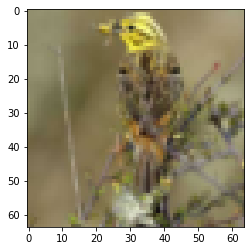

In [3]:
img, label = train_ds[0]
print(img.shape)
plt.imshow(to_pil_image(0.5*img+0.5))

In [4]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Model

In [5]:
params = {
    'nz':100, # noise
    'ngf':64, # number_generator_filter
    'ndf':64, # number_discriminator_filter
    'img_channel':3
}

In [6]:
class Generator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.nz = params['nz']
    self.ngf = params['ngf']
    self.img_channels = params['img_channel']

    self.generator = nn.Sequential(
        nn.ConvTranspose2d(self.nz, 1024, kernel_size=4, stride=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, self.img_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

  def forward(self, noise):
    x = self.generator(noise)
    return x


noise = torch.rand(1,100, 1, 1, device=device)
model_gen = Generator(params).to(device)
output_gen = model_gen(noise)
print(output_gen.shape)

torch.Size([1, 3, 64, 64])


In [7]:
class Discriminator(nn.Module):
  def __init__(self, parmas):
    super().__init__()
    self.nz = params['nz']
    self.img_channels = params['img_channel']
    self.ndf = params['ndf']

    self.discriminator = nn.Sequential(
        nn.Conv2d(self.img_channels, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 1, kernel_size=4, stride=1)
    )

  def forward(self, img):
    x = self.discriminator(img)
    x = torch.sigmoid(x)
    return x.view(-1, 1)

img = torch.rand(16, 3, 64, 64, device=device)
model_dis = Discriminator(img).to(device)
output_dis = model_dis(img)
print(output_dis.shape)

torch.Size([16, 1])


In [8]:
# 가중치 초기화
def initialize_weight(model):
  class_name = model.__class__.__name__
  if class_name.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
    print("init Conv!")
  if class_name.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)
    print("init BatchNorm!")

model_gen.apply(initialize_weight)
model_dis.apply(initialize_weight)

init Conv!
init BatchNorm!
init Conv!
init BatchNorm!
init Conv!
init BatchNorm!
init Conv!
init BatchNorm!
init Conv!
init Conv!
init Conv!
init BatchNorm!
init Conv!
init BatchNorm!
init Conv!
init BatchNorm!
init Conv!


Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

# Train

In [9]:
loss_func = nn.BCELoss()

from torch import optim
lr = 0.0002
beta1=0.5
beta2=0.999

opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))

In [10]:
model_gen.train()
model_dis.train()

num_epochs = 100
batch_count = 0
start_time = time.time()
nz = params['nz']
loss_hist = {
    'gen':[],
    'dis':[]
}

for epoch in range(num_epochs):
  for xb, yb in train_loader:
    batch = xb.shape[0]
    xb = xb.to(device)
    yb_real = torch.Tensor(batch, 1).fill_(1.0).to(device)
    yb_fake = torch.Tensor(batch, 1).fill_(0.0).to(device)

    # Generator
    noise = torch.randn(batch, 100, 1, 1).to(device)
    model_gen.zero_grad()
    output_gen = model_gen(noise)
    output_dis = model_dis(output_gen)

    loss_gen = loss_func(output_dis, yb_real)
    loss_gen.backward()
    opt_gen.step()

    # Discriminator
    model_dis.zero_grad()
    real_dis = model_dis(xb)
    loss_real = loss_func(real_dis, yb_real)
    fake_dis = model_dis(output_gen.detach())
    loss_fake = loss_func(fake_dis, yb_fake)

    loss_dis = (loss_real + loss_fake) / 2
    loss_dis.backward()
    opt_dis.step()

    loss_hist['gen'].append(loss_gen.item())
    loss_hist['dis'].append(loss_dis.item())

    batch_count += 1
    if batch_count % 100 == 0:
        print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' 
              %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 13.960121, D_Loss: 0.246107, time: 0.37 min
Epoch: 2, G_Loss: 2.074192, D_Loss: 0.436641, time: 0.73 min
Epoch: 3, G_Loss: 3.085983, D_Loss: 0.166638, time: 1.10 min
Epoch: 5, G_Loss: 5.094821, D_Loss: 0.590155, time: 1.46 min
Epoch: 6, G_Loss: 1.668358, D_Loss: 0.289327, time: 1.81 min
Epoch: 7, G_Loss: 1.424991, D_Loss: 0.413532, time: 2.18 min
Epoch: 8, G_Loss: 1.829731, D_Loss: 0.386008, time: 2.54 min
Epoch: 10, G_Loss: 2.370591, D_Loss: 0.118720, time: 2.89 min
Epoch: 11, G_Loss: 2.077581, D_Loss: 0.162516, time: 3.25 min
Epoch: 12, G_Loss: 1.783823, D_Loss: 0.225555, time: 3.61 min
Epoch: 13, G_Loss: 1.303529, D_Loss: 0.463227, time: 3.97 min
Epoch: 15, G_Loss: 1.719281, D_Loss: 0.293043, time: 4.33 min
Epoch: 16, G_Loss: 2.326667, D_Loss: 0.234956, time: 4.69 min
Epoch: 17, G_Loss: 3.116511, D_Loss: 0.215610, time: 5.05 min
Epoch: 18, G_Loss: 0.912003, D_Loss: 0.415739, time: 5.41 min
Epoch: 20, G_Loss: 2.596169, D_Loss: 0.181938, time: 5.77 min
Epoch: 21, G_L

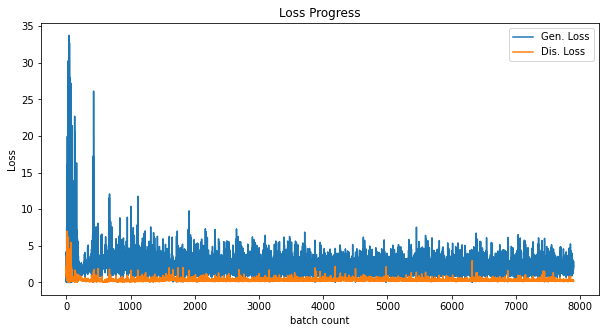

In [11]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 가짜 이미지 확인

torch.Size([16, 3, 64, 64])


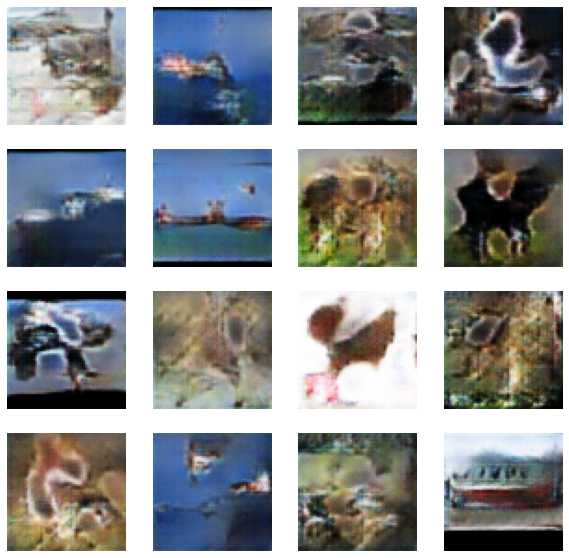

In [12]:
# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100,1,1, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')